## Experimenting with the model: 
using MLFlow to make first attempts with the model. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import tempfile

ModuleNotFoundError: No module named 'seaborn'

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

In [47]:
import tensorflow as tf
from tensorflow import keras
import mlflow
import mlflow.keras

In [3]:
data = pd.read_csv('../data/ibm_4y.csv')
data.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2017,1,3,06:56,$28.06,Chip Transaction,-5475680618560174533,Monterey Park,CA,91755.0,5942,NaN,No
1,0,0,2017,1,4,06:35,$46.07,Chip Transaction,-34551508091458520,La Verne,CA,91750.0,5912,NaN,No
2,0,0,2017,1,6,05:47,$31.08,Chip Transaction,4060646732831064559,La Verne,CA,91750.0,5411,NaN,No
3,0,0,2017,1,7,13:26,$11.48,Chip Transaction,-4500542936415012428,La Verne,CA,91750.0,5814,NaN,No
4,0,0,2017,1,8,06:37,$39.69,Chip Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


### Data Cleaning

In [49]:
def data_prep(data):
    """ processes the dataframe columns to desired format"""

    data.rename(str.lower, axis='columns', inplace=True)
    data.rename(columns={'use chip': 'use_chip', 
                        'merchant name': 'merchant_name', 
                        'merchant city': 'merchant_city', 
                        'merchant state': 'merchant_state',
                        'errors?': 'errors', 
                        'is fraud?': 'is_fraud' }, 
                        inplace=True)
    # set time series index
    data[['hour', 'minute']] = data['time'].str.split(':', expand=True)
    data['date'] = pd.to_datetime(data[['year', 'month', 'day', 'hour', 'minute']])
    data.set_index('date', inplace=True)
    data.sort_index(inplace=True)

    data.drop(columns=[ 'time'], inplace=True)
    
    # convert amount to float
    data['amount'] = data['amount'].str[1:].astype('float64')
    
    return data

In [50]:
data.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2017,1,3,06:56,$28.06,Chip Transaction,-5475680618560174533,Monterey Park,CA,91755.0,5942,NaN,No
1,0,0,2017,1,4,06:35,$46.07,Chip Transaction,-34551508091458520,La Verne,CA,91750.0,5912,NaN,No
2,0,0,2017,1,6,05:47,$31.08,Chip Transaction,4060646732831064559,La Verne,CA,91750.0,5411,NaN,No
3,0,0,2017,1,7,13:26,$11.48,Chip Transaction,-4500542936415012428,La Verne,CA,91750.0,5814,NaN,No
4,0,0,2017,1,8,06:37,$39.69,Chip Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


### PCA - coding and normalizing 

Train test split: including shuffle and stratify - since this is not a time series and there is no dependency between the datapoints. 
stratify - include positive class in every split equally. 

In [51]:
def data_spliter(data):
    """ takes fraud dataframe, performs train_test_split and applies scaling and encoding to features and labels
    performs initial bias calculation for the imbalanced dataset.
    returns xtrain, ytrain, xval, yval, xtest, ytest and initial bias"""

    # split to x (features) and y (labels), and split twice (train, val, test)
    X = data.drop(columns=['is_fraud'])
    y = data[['is_fraud']]
    Xtrain, xtest, Ytrain, ytest = train_test_split(X, 
                                                y, 
                                                test_size=0.2,      #test size default 25%
                                                random_state=42, 
                                                shuffle=True, 
                                                stratify=y) 
    xtrain, xval, ytrain, yval = train_test_split(Xtrain, 
                                                Ytrain, 
                                                test_size=0.25, 
                                                random_state=42, 
                                                shuffle=True, 
                                                stratify=Ytrain)   
    
    label_enc = LabelEncoder()

    # replace missing values with a constant text, then encode to numeric classes and scale
    state_pipe = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='online')),
        ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
        ('scaler', StandardScaler())])

    # replace missing values with zero, then encode and scale
    zero_pipe = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
        ('scaler', StandardScaler())
    ])

    # implement number scaler on numerical features (no missing values)
    # implement text replacement to state and errors
    # implement zero replacement to zip, city and chip
    transformer= ColumnTransformer(
        transformers=[
            ('number_scaler', StandardScaler(), [0, 1, 2, 3, 4, 5, 7, 11, 13, 14]),
            ('NAN_replace_text', state_pipe, [9, 12]),
            ('NAN_replace_zero', zero_pipe, [6, 8, 10]),
            
        ], remainder='drop', verbose_feature_names_out=False)  
    
    # apply label encoder on labels: 
    ytrain = label_enc.fit_transform(ytrain)
    yval = label_enc.fit_transform(yval)
    ytest = label_enc.transform(ytest)

    # apply pipeline on feature values
    transformer.fit(xtrain)
    xtrain = transformer.transform(xtrain)
    xval = transformer.transform(xval)
    xtest = transformer.transform(xtest)
    
    # set output bias with the fitted data encoder -
    # output bias is added as a constant matrix to the output layer of the model
    # and multiply the results to counter act the imbalance of the data classes
    neg, pos = np.bincount(label_enc.transform(y))
    sum = neg + pos
    initial_bias = np.log([pos/neg])
    
    # reshaping labels tensor to fit the model requirements of 2 dimensions
    ytrain = ytrain.reshape(ytrain.shape[0], 1)
    yval = yval.reshape(yval.shape[0], 1)

    return xtrain, ytrain, xval, yval, xtest, ytest, initial_bias

### Model build

In [72]:
def model_maker( metrics,  params):
    """builds a keras sequential from the params """
    
    output_bias = params['output_bias']
    if output_bias:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([keras.Input(shape=params['train_feature_size'])])
    for l in range(params['nr_of_layers']):
        layer = keras.layers.Dense(
            params['layer_size'][l],
            activation=params['activation1'],
            name=f'Denselayer{l+1}'
        )
        model.add(layer)
    
    model.add(keras.layers.Dropout(params['dropout']))
    model.add(keras.layers.Dense(1, activation='sigmoid',
                           bias_initializer=output_bias))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=params['learning_rate']),
        loss=keras.losses.BinaryCrossentropy(),               
        metrics=list(metrics.values())
    )

    return model

### Set model training 

In [53]:
def trainer(metrics, params, train_params, train_ds, val_ds, callback=None):
    """fix training according to the training params with the relevant sklearn metrics. 
    set early stopping callback, and other callbacs, if mentioned (relevant for loading initial weights).
    returns: model for training."""
    model = model_maker(metrics, params)
    
    eraly_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_prc',
        verbose=1,
        patience=train_params['patience'],
        mode='max',
        restore_best_weights=True
        )
    
    # set callbacks:
    callbacks_list = [eraly_stopping]
    if callback:
        callbacks_list.append(callback)
    try:
        initial_weights= train_params['initial_weights']
    
    # handle: if no weights are saved/loaded - tensorflow saves initial weights in tempfile. 
    except KeyError:
        
        train_params['initial_weights'] = os.path.join(tempfile.mkdtemp(), 'initial_weights.weights.h5')
        model.save_weights(train_params['initial_weights']) 
        print('weights saved')
        initial_weights= train_params['initial_weights']
        print(f'initial waights created: {initial_weights}')
    model.load_weights(initial_weights)
    
    if params['output_bias'] is None:
        
        model.layers[-1].bias.assign([0.0])
    
    # fit model to train and eval datasets:
    model.fit(
        train_ds, 
        batch_size=train_params['batch_size'],
        epochs=train_params['epochs'],
        validation_data=val_ds,
        verbose=1,
        callbacks=callbacks_list
    )

    return model
    

In [74]:
model_metrics = {
      'binary_crossentropy': keras.metrics.BinaryCrossentropy(name='binary_crossentropy'), 
      'Brier_score': keras.metrics.MeanSquaredError(name='Brier_score'),
      'tp':keras.metrics.TruePositives(name='tp'),
      'fp':keras.metrics.FalsePositives(name='fp'),
      'tn':keras.metrics.TrueNegatives(name='tn'),
      'fn':keras.metrics.FalseNegatives(name='fn'), 
      'accuracy':keras.metrics.BinaryAccuracy(name='accuracy'),
      'precision':keras.metrics.Precision(name='precision'),
      'recall':keras.metrics.Recall(name='recall'),
      'auc':keras.metrics.AUC(name='auc'),
      'prc':keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
}


params = {
    # logging: raise warning if the number of items in the list layer size 
    # is not smaller than the number of layers.
    'learning_rate': 1e-3,
    'output_bias': None,
    'dropout': 0.5,
    'train_feature_size': 15,   # =(xtrain.shape[-1],)),
    'layer_size': [16, 16, 32, 16],
    'activation1': 'relu',
    'nr_of_layers': 4
    }

train_params = {
    'patience': 10,
    'epochs' : 100,
    'batch_size': 2048,
}

In [55]:
data = data_prep(data)
data.head()

,user,card,year,month,day,amount,use_chip,merchant_name,merchant_city,merchant_state,zip,mcc,errors,is_fraud,hour,minute
date,,,,,,,,,,,,,,,,
2017-01-01 00:01:00,1130,2,2017,1,1,100.00,Chip Transaction,-4282466774399734331,San Marcos,TX,78666.0,4829,NaN,No,00,01
2017-01-01 00:01:00,182,0,2017,1,1,7.05,Online Transaction,-2088492411650162548,ONLINE,NaN,NaN,4784,NaN,No,00,01
2017-01-01 00:02:00,1596,0,2017,1,1,31.64,Online Transaction,-6160036380778658394,ONLINE,NaN,NaN,4121,NaN,No,00,02
2017-01-01 00:04:00,1777,2,2017,1,1,12.39,Online Transaction,-5841929396161652653,ONLINE,NaN,NaN,4121,NaN,No,00,04
2017-01-01 00:04:00,1490,0,2017,1,1,20.67,Chip Transaction,2027553650310142703,Tacoma,WA,98404.0,5541,NaN,No,00,04


In [ ]:
xtrain, ytrain, xval, yval, xtest, ytest, initial_bias = data_spliter(data)

In [57]:
params['output_bias'] = initial_bias

In [58]:
# data for TF logging: (examples.batch(20).prefetch(2) will prefetch 2 elements (2 batches, of 20 examples each).)
train_ds = tf.data.Dataset.from_tensor_slices((xtrain, ytrain)).batch(train_params['batch_size']).prefetch(2)
val_ds = tf.data.Dataset.from_tensor_slices((xval, yval)).batch(train_params['batch_size']).prefetch(2)
test_ds = tf.data.Dataset.from_tensor_slices((xtest, ytest)).batch(train_params['batch_size']).prefetch(1)


In [75]:
# test: 
model = model_maker(model_metrics, params)
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Denselayer1 (Dense)         (None, 16)                256       
                                                                 
 Denselayer2 (Dense)         (None, 16)                272       
                                                                 
 Denselayer3 (Dense)         (None, 32)                544       
                                                                 
 Denselayer4 (Dense)         (None, 16)                528       
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1617 (6.32 KB)
Trainable params: 1617 (

In [ ]:
model = trainer(model_metrics, params, train_params, train_ds, val_ds)

### Training

In [61]:
def mlflow_run(name, params, train_params, metrics, train_ds, val_ds, test_ds, run_name=None):
    """
    calls  model_maker and model_trainer functions, with MLFlow wrapper and params.
     tracks different model runs in experiments on mlrun server """
    tags = {k: v for k, v in params.items()}
    
    mlflow.set_experiment(name)
    experiment = mlflow.get_experiment_by_name(name)
    client = mlflow.tracking.MlflowClient()
    run = client.create_run(experiment.experiment_id)        
    mlflow.tensorflow.autolog(disable=True)
    with mlflow.start_run(run_name=run_name) as run: 
        logging_callback =  mlflow.tensorflow.MlflowCallback(run)
        mlflow.log_params(params)
        mlflow.log_params(train_params)
        mlflow.set_tags(tags)
        
        model = trainer(metrics, params, train_params, train_ds, val_ds, logging_callback)
        results = model.evaluate(test_ds, batch_size=train_params['batch_size'], verbose=1)
        predictions = model.predict(test_ds, batch_size=train_params['batch_size'])
        for name, value in zip(model.metrics_names, results):
            print(name, ': ', value)
        print(predictions)
        mlflow.tensorflow.log_model(model, "models")


        cm = ConfusionMatrixDisplay.from_predictions(
            np.concatenate([y for x, y in test_ds], axis=0), predictions > 0.2)
        
        mlflow.log_figure(cm.figure_, 'test_confusion_matrix.png')

In [ ]:
mlflow_run('zero_bias', params, train_params, model_metrics, train_ds, val_ds, test_ds, run_name='2 layers')

In [ ]:
train_params['initial_weights']

'/var/folders/z3/3pn18rh502z1fqy_wcbjxnfc0000gn/T/tmpx7pr0a6w/initial_weights.weights.h5'

### Evaluation
params view: 
params = {
    'learning_rate': 1e-3,
    'output_bias': None,
    'dropout': 0.5,
    'train_feature_size': 15,  
    'layer1_size': 16,
    'activation1': 'relu',
    'callbacks': []
    }

train_params = {
    'patience': 10,
    'epochs' : 100,   
    'batch_size': 2048,
    #'initial_weights': None
}

In [ ]:
params['output_bias'] = initial_bias
params['nr_of_layers'] = 2

In [ ]:
# test without output bias
train_pred_baseline = model.predict(xtrain, batch_size=params['batch_size'])
test_pred_baseline = model.predict(xtest, batch_size=params['batch_size'])

673/673 [==============================] - 1s 1ms/step


In [ ]:
def plot_cm(labels, predictions, threshold=0.5):
    cm = confusion_matrix(labels, predictions > threshold)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion matrix @{threshold:.2f}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    print('Legit transactions detected (True neg):', cm[0][0])
    print('Legit transactions incorrect detected (False pos):', cm[0][1])
    print('Fraud transactions missed (False neg):', cm[1][0])
    print('Fraud transactions detected (True Pos):', cm[1][1])
    print('Total fraud transactions:', np.sum(cm[1]))

673/673 [==============================] - 1s 2ms/step - loss: 0.0011 - cross entropy: 0.0011 - Brier score: 4.0501e-04 - tp: 57.0000 - fp: 1.0000 - tn: 1375277.0000 - fn: 1019.0000 - accuracy: 0.9993 - precision: 0.9828 - recall: 0.0530 - auc: 0.9999 - prc: 0.8557
loss :  0.0010817935690283775
cross entropy :  0.0010817935690283775
Brier score :  0.00040501364856027067
tp :  57.0
fp :  1.0
tn :  1375277.0
fn :  1019.0
accuracy :  0.9992589354515076
precision :  0.982758641242981
recall :  0.05297397822141647
auc :  0.9999229311943054
prc :  0.8556704521179199

Legit transactions detected (True neg): 1375277
Legit transactions incorrect detected (False pos): 1
Fraud transactions missed (False neg): 1019
Fraud transactions detected (True Pos): 57
Total fraud transactions: 1076


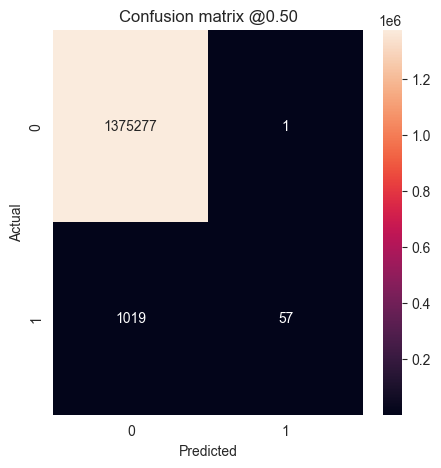

In [ ]:
baseline_results = model.evaluate(Xtest, ytest, batch_size=BATCH_SIZE, verbose=1)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()
plot_cm(ytest, test_pred_baseline)

Legit transactions detected (True neg): 1374971
Legit transactions incorrect detected (False pos): 307
Fraud transactions missed (False neg): 4
Fraud transactions detected (True Pos): 1072
Total fraud transactions: 1076
Legit transactions detected (True neg): 1374707
Legit transactions incorrect detected (False pos): 571
Fraud transactions missed (False neg): 0
Fraud transactions detected (True Pos): 1076
Total fraud transactions: 1076


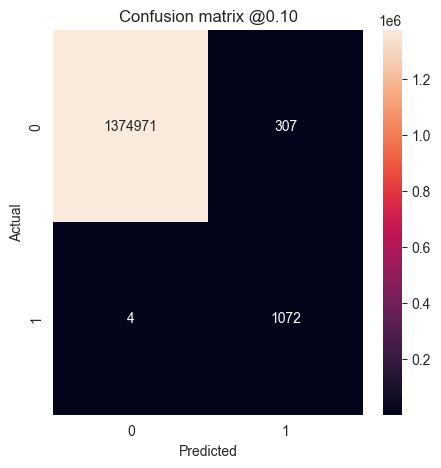

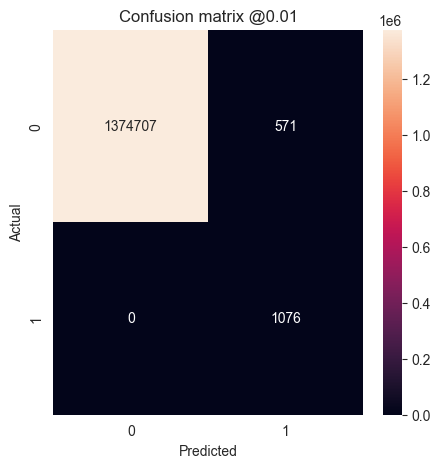

In [ ]:
plot_cm(ytest, test_pred_baseline, threshold=0.1)
plot_cm(ytest, test_pred_baseline, threshold=0.01)

In [ ]:
#ROC - Receiver Operator Characteristic- 
#TPR vs FPR at various threshold values: separates the 'signal' from the 'noise'.)
#true positive rate (TPR) on the Y axis, and false positive rate (FPR) on the X axis
def plot_roc(name, labels, preds, **kwargs):        
    fpr, tpr, _ = metrics.roc_curve(labels, preds)            # _ for thresholds
    #metrics.RocCurveDisplay.from_predictions(labels, preds, pos_label= 'Detected Fraud', name=name)
    print(len(fpr))
   
    print(len(tpr))
    plt.plot(100*fpr, 100*tpr, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,25])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

    return fpr, tpr

    


438870
438870
123037
123037


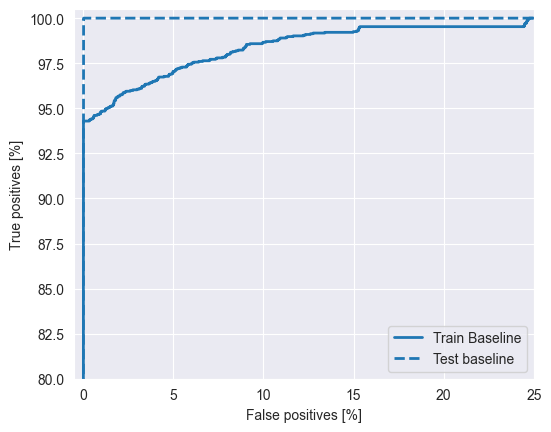

In [ ]:
train_fp, train_tp = plot_roc('Train Baseline', ytrain, train_pred_baseline, color=colors[0])
test_fp, test_tp = plot_roc('Test baseline', ytest, test_pred_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

plot area under the curve: AUPRC - area under the percision-recall 

In [ ]:
def plot_prc(name, labels, preds, **kwargs):
    precision, recall, _ = metrics.precision_recall_curve(labels, preds)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

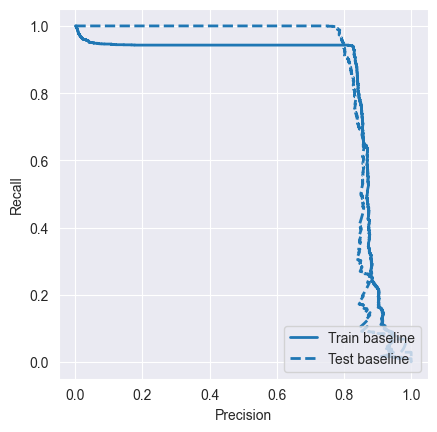

In [ ]:
plot_prc('Train baseline', ytrain, train_pred_baseline, color=colors[0])
plot_prc('Test baseline', ytest, test_pred_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [ ]:
weight_0 = (1 / neg) * (sum / 2.0)
weight_1 = (1 / pos) * (sum / 2.0)

class_weight = {0: weight_0, 1: weight_1}

print(f'weight class 0: {weight_0:.2f}')
print(f'weight class 1: {weight_1:.2f}')

weight class 0: 0.50
weight class 1: 569.56


Training with class weight: 

In [ ]:
weighted_model = create_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    xtrain,
    ytrain,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[eraly_stopping],
    validation_data=(xval, yval),
    class_weight=class_weight
)

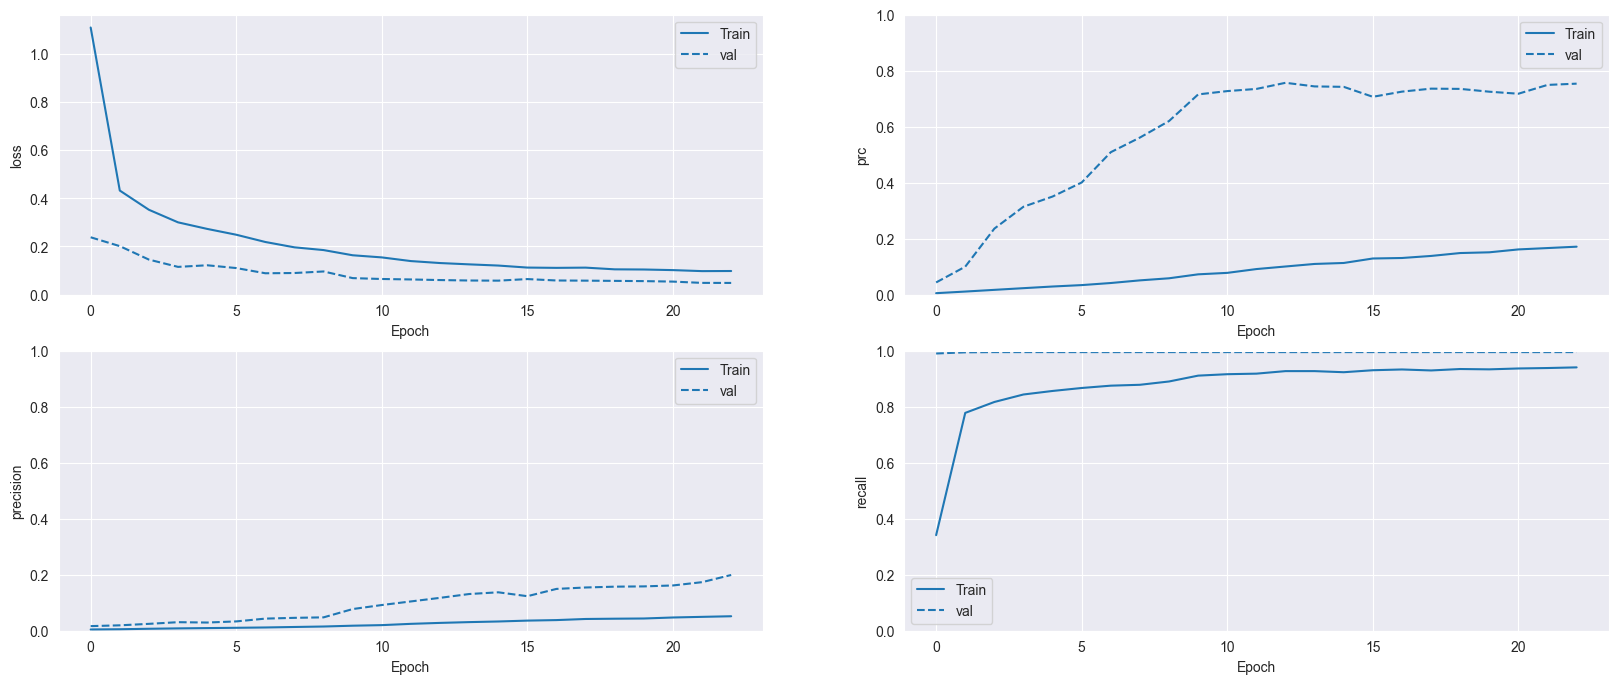

In [ ]:
plot_metrics(weighted_history)

In [ ]:
train_pred_weighted = weighted_model.predict(xtrain, batch_size=BATCH_SIZE)
test_pred_weighted = weighted_model.predict(Xtest, batch_size=BATCH_SIZE)

673/673 [==============================] - 1s 1ms/step


In [ ]:
train_pred_baseline.shape, train_pred_weighted.shape

((3303247, 1), (3303247, 1))

In [ ]:
weighted_results = weighted_model.evaluate(Xtest, ytest, batch_size=BATCH_SIZE, verbose=0)

loss :  0.06233307346701622
cross entropy :  0.06233307346701622
Brier score :  0.014253773726522923
tp :  1076.0
fp :  16321.0
tn :  1358957.0
fn :  0.0
accuracy :  0.9881418347358704
precision :  0.061849743127822876
recall :  1.0
auc :  0.9998019337654114
prc :  0.7081114649772644

Legit transactions detected (True neg): 1358957
Legit transactions incorrect detected (False pos): 16321
Fraud transactions missed (False neg): 0
Fraud transactions detected (True Pos): 1076
Total fraud transactions: 1076


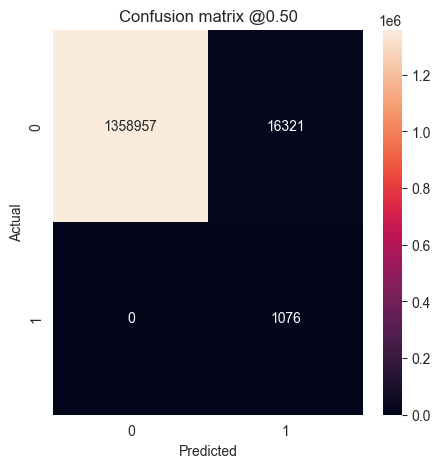

In [ ]:
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()
plot_cm(ytest, test_pred_weighted)

438870
438870
123037
123037
417452
417452
113520
113520


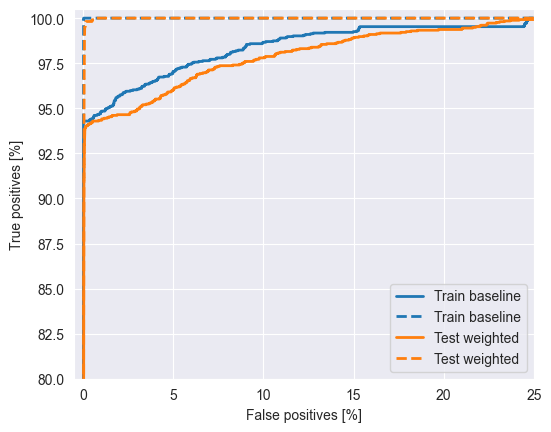

In [ ]:
plot_roc('Train baseline', ytrain, train_pred_baseline, color=colors[0])
plot_roc('Train baseline', ytest, test_pred_baseline, color=colors[0], linestyle='--')

plot_roc('Test weighted', ytrain, train_pred_weighted, color=colors[1])
plot_roc('Test weighted', ytest, test_pred_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right')

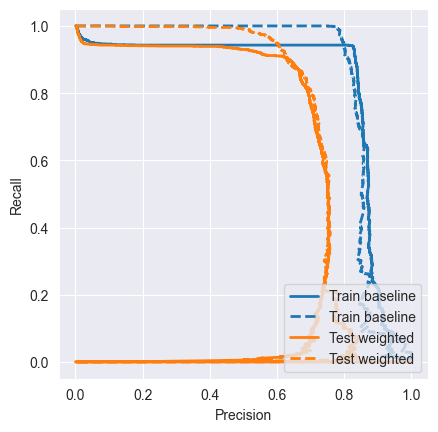

In [ ]:
plot_prc('Train baseline', ytrain, train_pred_baseline, color=colors[0])
plot_prc('Train baseline', ytest, test_pred_baseline, color=colors[0], linestyle='--')

plot_prc('Test weighted', ytrain, train_pred_weighted, color=colors[1])
plot_prc('Test weighted', ytest, test_pred_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right')

In [2]:
import pandas as pd

In [3]:
TRAIN_DATES = {'dates': 
               pd.Series(pd.to_datetime(pd.date_range('2019-01-01','2020-02-01',freq='MS').strftime("%b-%y").tolist(), format='%b-%y'
))
}


In [9]:
TRAIN_DATES['dates'][0]

Timestamp('2019-01-01 00:00:00')

In [15]:
import pandas as pd
df = pd.read_csv('../data/clean_cc_data.csv')

In [23]:
short = df[:5]


In [24]:
short.reset_index(inplace=True)
short.rename(columns={'index': 'time_stamp'})
short.dtypes

index              object
user                int64
card                int64
year                int64
month               int64
day                 int64
amount            float64
use_chip           object
merchant_name       int64
merchant_city      object
merchant_state     object
zip               float64
mcc                 int64
errors             object
is_fraud           object
hour                int64
minute              int64
dtype: object

In [20]:
short.head()

,user,card,year,month,day,amount,use_chip,merchant_name,merchant_city,merchant_state,zip,mcc,errors,is_fraud,hour,minute
2017-01-01 00:01:00,1130,2,2017,1,1,100.00,Chip Transaction,-4282466774399734331,San Marcos,TX,78666.0,4829,NaN,No,0,1
2017-01-01 00:01:00,182,0,2017,1,1,7.05,Online Transaction,-2088492411650162548,ONLINE,NaN,NaN,4784,NaN,No,0,1
2017-01-01 00:02:00,1596,0,2017,1,1,31.64,Online Transaction,-6160036380778658394,ONLINE,NaN,NaN,4121,NaN,No,0,2
2017-01-01 00:04:00,1777,2,2017,1,1,12.39,Online Transaction,-5841929396161652653,ONLINE,NaN,NaN,4121,NaN,No,0,4
2017-01-01 00:04:00,1490,0,2017,1,1,20.67,Chip Transaction,2027553650310142703,Tacoma,WA,98404.0,5541,NaN,No,0,4
